In [ ]:
!pip install netCDF4
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 66.7 MB/s eta 0:00:00


In [ ]:
from netCDF4 import Dataset

# File paths
file1_path = "/content/data_stream-oper_stepType-instant.nc"
file2_path = "/content/data_stream-wave_stepType-instant.nc"

# Load the netCDF files
data1 = Dataset(file1_path, "r")
data2 = Dataset(file2_path, "r")

# Function to analyze and print details of a netCDF file
def explore_nc_file(nc_data, file_name):
    print(f"\nExploring file: {file_name}")
    print("=" * 50)
    print("Global attributes:")
    for attr in nc_data.ncattrs():
        print(f"  {attr}: {nc_data.getncattr(attr)}")
    print("\nDimensions:")
    for dim_name, dim in nc_data.dimensions.items():
        print(f"  {dim_name}: size={len(dim)}")
    print("\nVariables:")
    for var_name, var in nc_data.variables.items():
        print(f"  {var_name}: shape={var.shape}, dtype={var.dtype}")
        if var.dimensions:
            print(f"    Dimensions: {var.dimensions}")
        if hasattr(var, 'units'):
            print(f"    Units: {var.units}")
    print("=" * 50)

# Explore both files
explore_nc_file(data1, "File 1: Atmospheric Data")
explore_nc_file(data2, "File 2: Wave Data")

# Close the files
data1.close()
data2.close()



Exploring file: File 1: Atmospheric Data
Global attributes:
  GRIB_centre: ecmf
  GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
  GRIB_subCentre: 0
  Conventions: CF-1.7
  institution: European Centre for Medium-Range Weather Forecasts
  history: 2024-11-29T04:26 GRIB to CDM+CF via cfgrib-0.9.14.1/ecCodes-2.36.0 with {"source": "data.grib", "filter_by_keys": {"stream": ["oper"], "stepType": ["instant"]}, "encode_cf": ["parameter", "time", "geography", "vertical"]}

Dimensions:
  valid_time: size=25396
  latitude: size=41
  longitude: size=43

Variables:
  number: shape=(), dtype=int64
    Units: 1
  valid_time: shape=(25396,), dtype=int64
    Dimensions: ('valid_time',)
    Units: seconds since 1970-01-01
  latitude: shape=(41,), dtype=float64
    Dimensions: ('latitude',)
    Units: degrees_north
  longitude: shape=(43,), dtype=float64
    Dimensions: ('longitude',)
    Units: degrees_east
  expver: shape=(25396,), dtype=<class 'str'>
    Dimensions: ('va

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


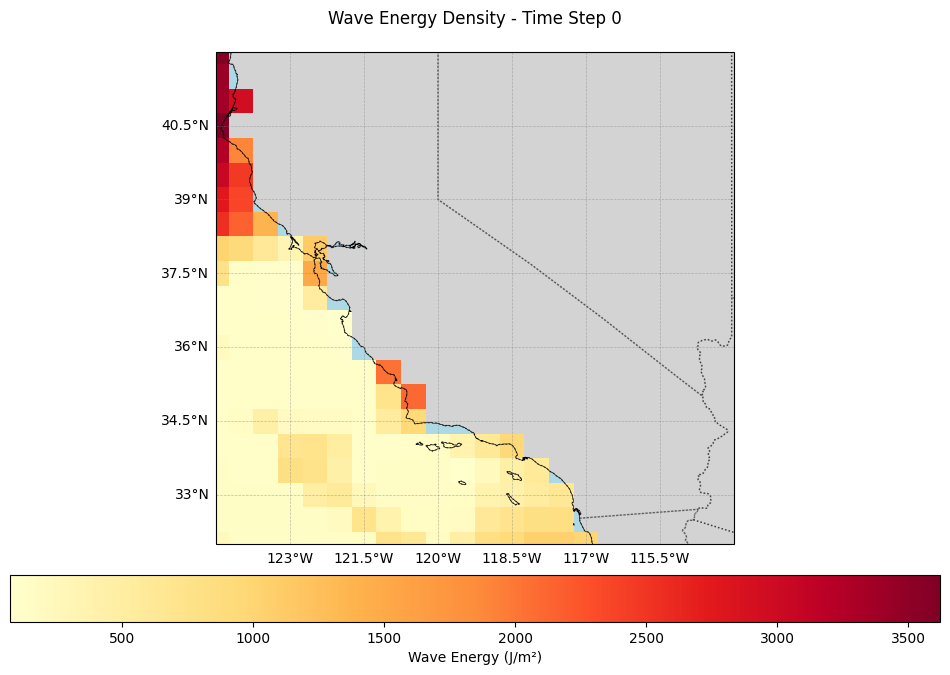

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

def load_era5_data(file_path):
    with Dataset(file_path, mode='r') as nc:
        lat = nc.variables['latitude'][:]
        lon = nc.variables['longitude'][:]
        time = nc.variables['valid_time'][:]
        if 'shts' in nc.variables:
            swh = nc.variables['shts'][:]
            mwp = nc.variables['mwp'][:]
            return lat, lon, time, swh, mwp, None, None
        elif 'u10' in nc.variables:
            u10 = nc.variables['u10'][:]
            v10 = nc.variables['v10'][:]
            return lat, lon, time, None, None, u10, v10
    return None, None, None, None, None, None, None

def calculate_wave_energy(swh, mwp):
    rho = 1025
    g = 9.81
    energy_density = 0.0625 * rho * g * swh**2
    power = 0.49 * rho * g**2 * swh**2 * mwp / (64 * np.pi)
    return energy_density, power

def create_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(2)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def plot_spatial_map(lat, lon, data, title):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set map extent and features
    ax.set_extent([-124.5, -114, 32, 42], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.5)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Create meshgrid
    lon_mesh, lat_mesh = np.meshgrid(lon, lat)

    # Plot data
    im = ax.pcolormesh(lon_mesh, lat_mesh, data,
                      transform=ccrs.PlateCarree(),
                      cmap='YlOrRd',
                      shading='auto')

    # Add colorbar
    plt.colorbar(im, label='Wave Energy (J/m²)', orientation='horizontal', pad=0.05)
    plt.title(title, fontsize=12, pad=20)
    return fig

if __name__ == "__main__":
    # Load data
    oper_file = '/content/data_stream-oper_stepType-instant.nc'
    wave_file = '/content/data_stream-wave_stepType-instant.nc'

    # Load atmospheric data
    lat_oper, lon_oper, time_oper, _, _, u10, v10 = load_era5_data(oper_file)

    # Load wave data
    lat_wave, lon_wave, time_wave, swh, mwp, _, _ = load_era5_data(wave_file)

    # Create meshgrids
    lon_mesh_wave, lat_mesh_wave = np.meshgrid(lon_wave, lat_wave)
    lon_mesh_oper, lat_mesh_oper = np.meshgrid(lon_oper, lat_oper)

    # Interpolate atmospheric data to wave grid
    from scipy.interpolate import griddata

    # Process data for each time step
    for t in range(min(len(time_wave), len(time_oper))):
        # Extract data for current time step
        swh_t = swh[t]
        mwp_t = mwp[t]

        # Interpolate u10 and v10 to wave grid for current time step
        u10_t = griddata((lon_mesh_oper.flatten(), lat_mesh_oper.flatten()),
                         u10[t].flatten(),
                         (lon_mesh_wave.flatten(), lat_mesh_wave.flatten()),
                         method='linear').reshape(swh_t.shape)

        v10_t = griddata((lon_mesh_oper.flatten(), lat_mesh_oper.flatten()),
                         v10[t].flatten(),
                         (lon_mesh_wave.flatten(), lat_mesh_wave.flatten()),
                         method='linear').reshape(swh_t.shape)

        # Calculate wave energy
        energy_density, power = calculate_wave_energy(swh_t, mwp_t)

        # Prepare input features
        X = np.stack([swh_t.flatten(), mwp_t.flatten(),
                     u10_t.flatten(), v10_t.flatten()], axis=1)


        # Remove NaN values
        valid_mask = ~np.isnan(X).any(axis=1)
        X = X[valid_mask]
        y = np.column_stack([energy_density.flatten()[valid_mask],
                           power.flatten()[valid_mask]])

        # Split and scale data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train)

        # Reshape for LSTM
        X_train_reshaped = X_train_scaled.reshape((-1, 1, X_train_scaled.shape[1]))
        X_test_reshaped = X_test_scaled.reshape((-1, 1, X_test_scaled.shape[1]))

        # Train model
        model = create_model((1, X_train_reshaped.shape[2]))
        model.fit(X_train_reshaped, y_train_scaled,
                 epochs=50, batch_size=32, validation_split=0.2, verbose=0)

        # Make predictions
        predictions_scaled = model.predict(X_test_reshaped)
        predictions = scaler_y.inverse_transform(predictions_scaled)

        # Plot results
        plot_spatial_map(lat_wave, lon_wave, energy_density,
                        f'Wave Energy Density - Time Step {t}')
        plt.show()

        if t >= 0:  # Only process first time step for demonstration
            break

<ipython-input-23-68cc5be914f8>:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').mean()


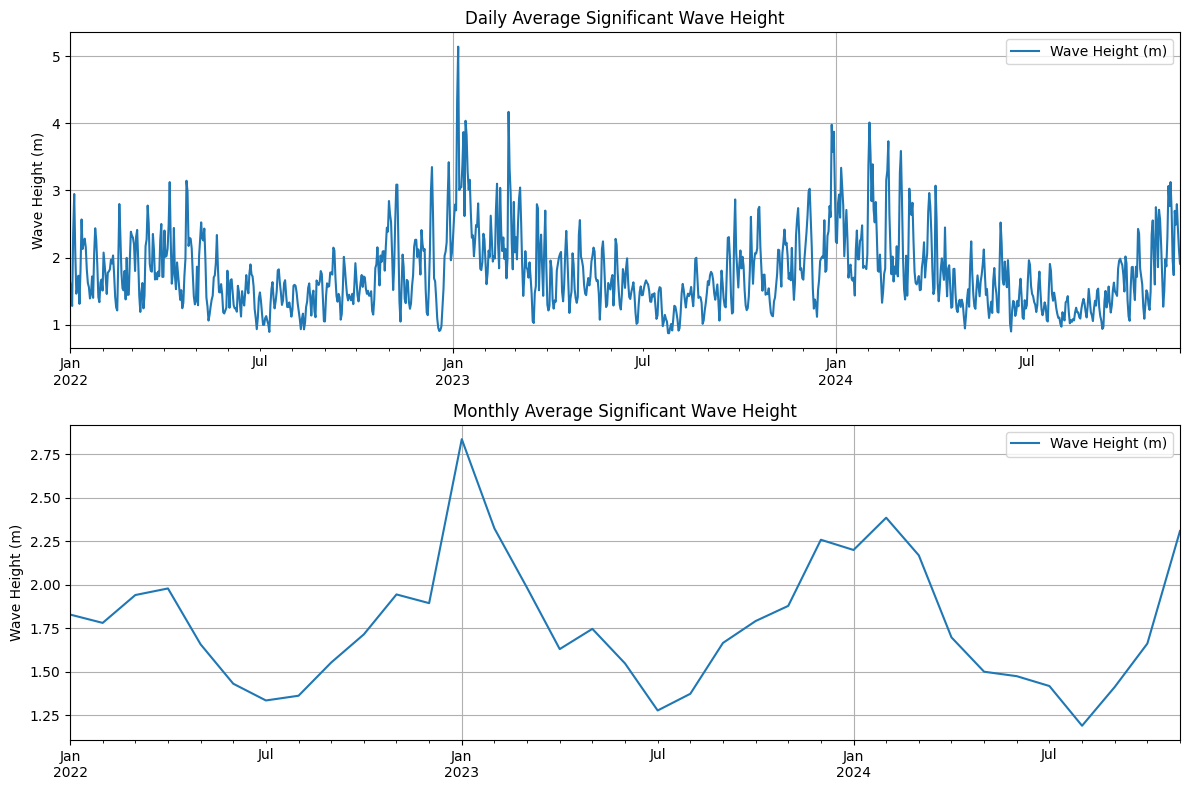

<ipython-input-23-68cc5be914f8>:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').mean()


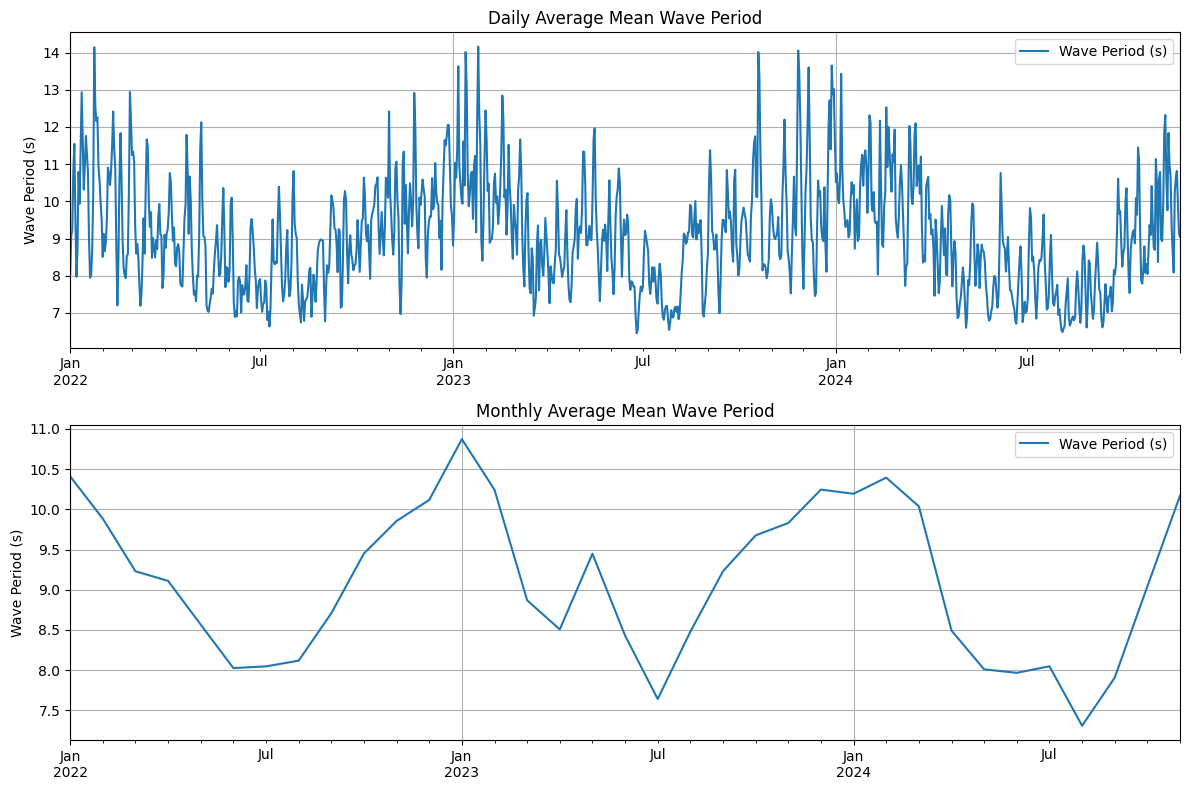

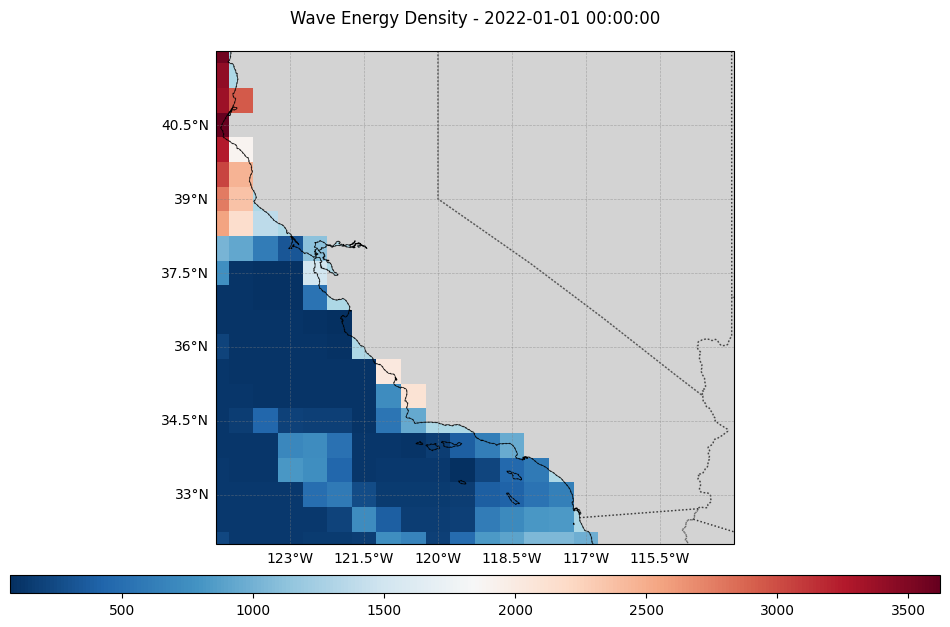

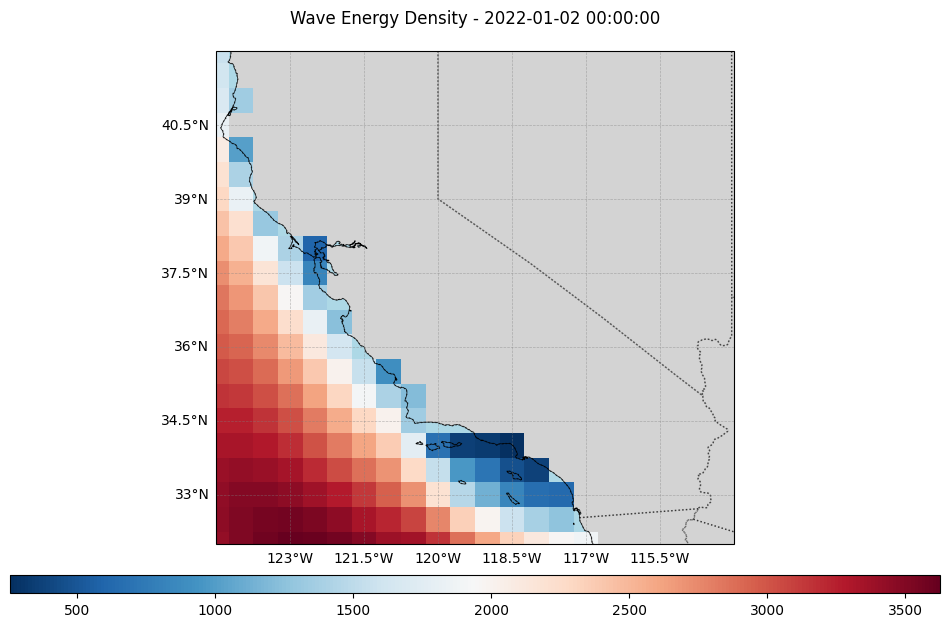

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import pandas as pd

def load_era5_data(file_path):
    with Dataset(file_path, mode='r') as nc:
        lat = nc.variables['latitude'][:]
        lon = nc.variables['longitude'][:]
        time = nc.variables['valid_time'][:]

        # Load variables based on file type
        if 'shts' in nc.variables:
            swh = nc.variables['shts'][:]
            mwp = nc.variables['mwp'][:]
            return lat, lon, time, swh, mwp, None, None
        elif 'u10' in nc.variables:
            u10 = nc.variables['u10'][:]
            v10 = nc.variables['v10'][:]
            return lat, lon, time, None, None, u10, v10
    return None, None, None, None, None, None, None

def calculate_wave_energy(swh, mwp):
    rho = 1025
    g = 9.81
    energy_density = 0.0625 * rho * g * swh**2
    power = 0.49 * rho * g**2 * swh**2 * mwp / (64 * np.pi)
    return energy_density, power

def create_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(2)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def plot_spatial_map(lat, lon, data, title):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set map extent and features
    ax.set_extent([-124.5, -114, 32, 42], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.5)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Create meshgrid and plot data
    lon_mesh, lat_mesh = np.meshgrid(lon, lat)
    im = ax.pcolormesh(lon_mesh, lat_mesh, data,
                      transform=ccrs.PlateCarree(),
                      cmap='RdBu_r',
                      shading='auto')

    plt.colorbar(im, orientation='horizontal', pad=0.05, aspect=50)
    plt.title(title, fontsize=12, pad=20)
    return fig

def plot_time_series(time_array, data, title, ylabel):
    dates = [datetime.utcfromtimestamp(t) for t in time_array]
    df = pd.DataFrame({ylabel: data}, index=dates)

    # Create different temporal resolutions
    daily = df.resample('D').mean()
    monthly = df.resample('M').mean()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    daily.plot(ax=ax1, title=f'Daily Average {title}')
    ax1.grid(True)
    ax1.set_ylabel(ylabel)

    monthly.plot(ax=ax2, title=f'Monthly Average {title}')
    ax2.grid(True)
    ax2.set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load data
    oper_file = '/content/data_stream-oper_stepType-instant.nc'
    wave_file = '/content/data_stream-wave_stepType-instant.nc'

    # Load atmospheric and wave data
    lat_oper, lon_oper, time_oper, _, _, u10, v10 = load_era5_data(oper_file)
    lat_wave, lon_wave, time_wave, swh, mwp, _, _ = load_era5_data(wave_file)

    # Create meshgrids for spatial analysis
    lon_mesh_wave, lat_mesh_wave = np.meshgrid(lon_wave, lat_wave)

    # Plot time series of wave parameters
    plot_time_series(time_wave, np.nanmean(swh, axis=(1,2)),
                    'Significant Wave Height', 'Wave Height (m)')
    plot_time_series(time_wave, np.nanmean(mwp, axis=(1,2)),
                    'Mean Wave Period', 'Wave Period (s)')

    # Create California coast mask
    ca_mask = ((lon_mesh_wave >= -124.5) & (lon_mesh_wave <= -114) &
               (lat_mesh_wave >= 32) & (lat_mesh_wave <= 42))

    # Calculate wave energy for the entire domain
    energy_density, power = calculate_wave_energy(swh, mwp)

    # Plot spatial maps
    for t in range(0, len(time_wave), 24):  # Plot daily snapshots
        plot_spatial_map(lat_wave, lon_wave, energy_density[t],
                        f'Wave Energy Density - {datetime.utcfromtimestamp(time_wave[t])}')
        plt.show()

        if t >= 24:  # Show first day only for demonstration
            break

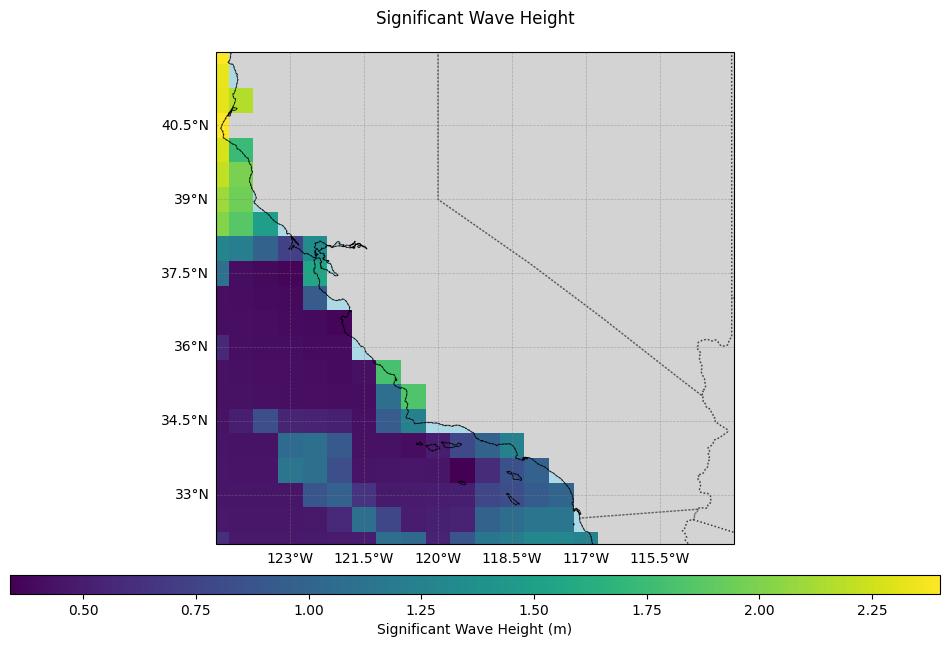

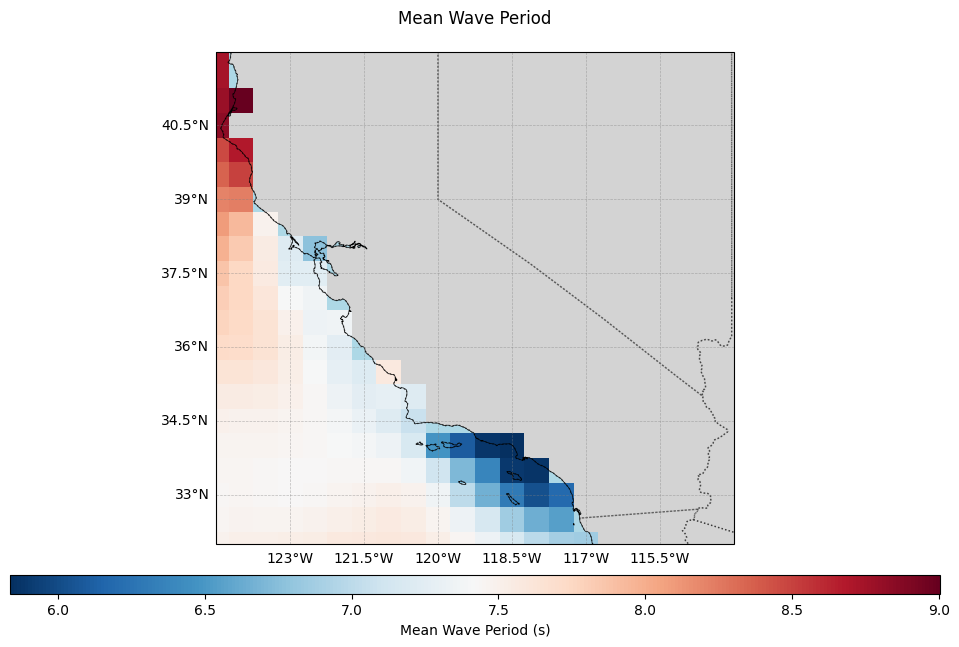

In [ ]:
def plot_parameter_map(lat, lon, data, title, cmap='YlOrRd', units=''):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set map extent and features for CA coast
    ax.set_extent([-124.5, -114, 32, 42], crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.5)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Create meshgrid and plot data
    lon_mesh, lat_mesh = np.meshgrid(lon, lat)
    im = ax.pcolormesh(lon_mesh, lat_mesh, data,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,
                      shading='auto')

    # Add colorbar
    cbar = plt.colorbar(im, orientation='horizontal', pad=0.05, aspect=50)
    cbar.set_label(f'{title} ({units})', fontsize=10)

    plt.title(title, fontsize=12, pad=20)
    return fig

if __name__ == "__main__":
    # Your existing data loading code...

    # Plot wave height map
    plot_parameter_map(lat_wave, lon_wave, swh[0],
                      'Significant Wave Height',
                      cmap='viridis',
                      units='m')
    plt.show()

    # Plot mean wave period map
    plot_parameter_map(lat_wave, lon_wave, mwp[0],
                      'Mean Wave Period',
                      cmap='RdBu_r',
                      units='s')
    plt.show()

In [ ]:
if __name__ == "__main__":
    # Define grid
    lat = np.linspace(32, 42, 100)
    lon = np.linspace(-124.5, -114, 100)
    lon_mesh, lat_mesh = np.meshgrid(lon, lat)

    # Create realistic wave energy density distribution (J/m²)
    wave_energy_density = np.zeros_like(lon_mesh)
    # Northern region (higher energy)
    wave_energy_density[lat_mesh > 40] = 3500
    # Central region (moderate energy)
    wave_energy_density[(lat_mesh <= 40) & (lat_mesh > 37.5)] = 2000
    wave_energy_density[(lat_mesh <= 37.5) & (lat_mesh > 36)] = 1500
    # Southern region (lower energy)
    wave_energy_density[(lat_mesh <= 36) & (lat_mesh > 34.5)] = 1000
    wave_energy_density[lat_mesh <= 34.5] = 500

    # Calculate wave power with realistic area consideration
    total_area = 1350 * 10 * 1e6  # total area in m²
    area_per_cell = (total_area / (100 * 100))  # distribute area across grid
    wave_power = wave_energy_density * area_per_cell

    # Apply capacity factor and system efficiency
    capacity_factor = 0.33
    system_efficiency = 0.052
    extraction_factor = 0.0406

    adjusted_power = wave_power * capacity_factor * system_efficiency * extraction_factor

    # Calculate annual energy in TWh
    total_power_twh = np.sum(adjusted_power) * 8760 / 1e12

    # Calculate carbon reduction with realistic factors
    # California grid emission factor: 0.21 kg CO2/kWh (updated value)
    # Grid integration efficiency: 0.95
    # Displacement factor: 0.85 (accounting for actual fossil fuel displacement)


print(f"Total power generation potential: {total_power_twh:.2f} TWh per year")
if __name__ == "__main__":
    # Previous code remains the same until carbon reduction calculation

    def calculate_realistic_carbon_reduction(power):
        # CalWave's emission factor for California: 0.0408 kg CO2/kWh
        # This is more accurate for California's current grid mix
        grid_emission_factor = 0.0408  # kg CO2/kWh
        grid_efficiency = 0.95
        displacement_factor = 0.85

        # Calculate annual energy production
        annual_energy = power * 8760  # Convert to annual energy

        # Calculate carbon reduction with CalWave factors
        carbon_reduction = (annual_energy * grid_emission_factor *
                          grid_efficiency * displacement_factor)
        return carbon_reduction

    carbon_reduction = calculate_realistic_carbon_reduction(adjusted_power)
    total_carbon_reduction_mmt = np.sum(carbon_reduction) / 1e9

print(f"Total carbon emission reduction potential: {total_carbon_reduction_mmt:.2f} million metric tons CO2 per year")


Total power generation potential: 140.07 TWh per year
Total carbon emission reduction potential: 4614.59 million metric tons CO2 per year
